# 📘 Masar Station-Level 30-Minute Demand Forecasting Notebook

This notebook builds a complete machine-learning pipeline for forecasting station-level passenger demand 30 minutes ahead. It processes raw Masar data, engineers time-based and operational features, encodes categorical attributes, and trains a Random Forest model to learn short-term passenger flow dynamics.

By leveraging historical patterns, lag variables, event indicators, and service features, the model produces reliable short-term forecasts that support simulation workflows, operational planning, and real-time decision systems.

# 🎯 Purpose

The objective of this notebook is to construct a predictive model that estimates future passenger counts based on:

* Time-of-day and weekday behavior
* Operational variables (headway, modifiers, flows)
* Recency-based lag features
* Event and holiday disruptions
* Station identity and historical movement patterns

The output serves as a foundational forecasting component for downstream simulation engines, demand-adjustment modules, and deployment pipelines.

In [2]:
!git clone https://github.com/Jana-Alrzoog/2025_GP_28.git
%cd 2025_GP_28


Cloning into '2025_GP_28'...
remote: Enumerating objects: 1027, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 1027 (delta 129), reused 73 (delta 30), pack-reused 760 (from 4)
Receiving objects: 100% (1027/1027), 42.13 MiB | 18.01 MiB/s, done.
Resolving deltas: 100% (409/409), done.
/content/2025_GP_28/2025_GP_28


# Load & Prepare September Dataset

In [3]:
# ============================================================
# 1. Load and Prepare Dataset
# ============================================================

import pandas as pd

df = pd.read_csv(
    "masar-sim/data/generated/2025-09_StationData.csv",
    parse_dates=["timestamp"]
)

df = df.sort_values(["station_id", "timestamp"]).reset_index(drop=True)
df.head()


/tmp/ipython-input-3681429631.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,date,timestamp,hour,minute_of_day,day_of_week,is_weekend,station_id,headway_seconds,base_demand,modifier,...,holiday_flag,lag_5,lag_15,lag_30,lag_60,lag_120,roll_mean_15,roll_std_15,roll_mean_60,target_30min
0,2025-09-01,2025-09-01 00:00:00,0,0,0,0,S1,660,0.110000,1.0,...,0,NaN,NaN,NaN,NaN,NaN,154.0,NaN,154.0,NaN
1,2025-09-01,2025-09-01 06:00:00,6,360,0,0,S1,660,0.210551,1.0,...,0,NaN,NaN,NaN,NaN,NaN,295.0,NaN,295.0,NaN
2,2025-09-01,2025-09-01 06:01:00,6,361,0,0,S1,660,0.216663,1.0,...,0,NaN,NaN,NaN,NaN,NaN,299.5,6.363961,299.5,NaN
3,2025-09-01,2025-09-01 06:02:00,6,362,0,0,S1,660,0.223091,1.0,...,0,NaN,NaN,NaN,NaN,NaN,304.0,9.000000,304.0,NaN
4,2025-09-01,2025-09-01 06:03:00,6,363,0,0,S1,660,0.229847,1.0,...,0,NaN,NaN,NaN,NaN,NaN,308.5,11.618950,308.5,NaN


# Preprocess Lag and Rolling Window Features

In [4]:
# ============================================================
# 2. Clean Lag and Rolling-Window Features
# ============================================================

lag_roll_cols = [
    "lag_5", "lag_15", "lag_30", "lag_60", "lag_120",
    "roll_mean_15", "roll_std_15", "roll_mean_60"
]

df[lag_roll_cols] = df[lag_roll_cols].fillna(0)


In [5]:
# ============================================================
# 3. Construct 30-Minute Future Target
# ============================================================

df["target_30m"] = df.groupby("station_id")["station_total"].shift(-30)
df = df.dropna(subset=["target_30m"]).reset_index(drop=True)
df["target_30m"] = df["target_30m"].astype(float)


In [6]:
# ============================================================
# 4. Engineer Temporal Features
# ============================================================

df["hour"] = df["timestamp"].dt.hour
df["minute_of_day"] = df["timestamp"].dt.hour * 60 + df["timestamp"].dt.minute
df["day_of_week"] = df["timestamp"].dt.weekday
df["is_weekend"] = df["day_of_week"].isin([4, 5]).astype(int)


# Encoding Station Identifiers (S1–S6)

In [7]:
# ============================================================
# 5️. Encode Station Identifiers
# ============================================================

fixed_station_order = ["S1", "S2", "S3", "S4", "S5", "S6"]

station_mapping = {name: idx+1 for idx, name in enumerate(fixed_station_order)}

df["station_id_mapped"] = df["station_id"].map(station_mapping)

# Preprocess & Encode Special Event Types

In [8]:
# ============================================================
# 6️. Encode Special Event Categories
# ============================================================

df["special_event_type"] = df["special_event_type"].fillna("None")

fixed_event_order = [
    "None",
    "Festival",
    "Sports",
    "NationalHoliday",
    "Holiday",
    "Conference",
    "Exhibition",
    "Concert",
    "Expo",
    "AirportSurge"
]
event_mapping = {name: idx for idx, name in enumerate(fixed_event_order)}

df["special_event_type"] = df["special_event_type"].fillna("None")
df["special_event_type_mapped"] = df["special_event_type"].map(event_mapping)

In [9]:
# ============================================================
# 7️. Build Feature Matrix (X) and Target Vector (y)
# ============================================================

feature_cols = [
    "hour", "minute_of_day", "day_of_week", "is_weekend",
    "station_id_mapped", "headway_seconds", "station_flow_per_min", "special_event_type_mapped",
    "event_flag", "holiday_flag", "station_total",
    "lag_5", "lag_15", "lag_30", "lag_60", "lag_120",
    "roll_mean_15", "roll_std_15", "roll_mean_60",
]


In [10]:
X = df[feature_cols].copy()
y = df["target_30m"].copy()


# Create Time-Based Train/Val/Test Split

In [11]:
# ============================================================
# 8. Chronological Train-Test Split
# ============================================================

total_len = len(df)

train_end = int(total_len * 0.70)
val_end   = int(total_len * 0.85)


X_train = X.iloc[:train_end]
X_val   = X.iloc[train_end:val_end]
X_test  = X.iloc[val_end:]


y_train = y.iloc[:train_end]
y_val   = y.iloc[train_end:val_end]
y_test  = y.iloc[val_end:]

print(len(X_train), len(X_val), len(X_test))


136080 29160 29160


# Define and Fit the Random Forest Regression Model

In [34]:
# ============================================================
# 9️. Train Random Forest Regressor
# ============================================================

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
 n_estimators=150,
    max_depth=8,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, min_samples_leaf=3, n_estimators=150,
                      n_jobs=-1, random_state=42)

# Model Evaluation: RMSE, MAE, and R² Scores

In [35]:
# ============================================================
# 10. Evaluate Model Performance (Train / Val / Test)
# ============================================================

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from math import sqrt

# -------- TRAIN --------
y_pred_train = rf_model.predict(X_train)
train_mae  = mean_absolute_error(y_train, y_pred_train)
train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
train_r2   = r2_score(y_train, y_pred_train)

print("Train metrics:")
print("RMSE:", round(train_rmse, 2))
print("MAE :", round(train_mae, 2))
print("R^2 :", round(train_r2, 3))
print("\n")

# -------- VALIDATION --------
y_pred_val = rf_model.predict(X_val)
val_mae  = mean_absolute_error(y_val, y_pred_val)
val_rmse = sqrt(mean_squared_error(y_val, y_pred_val))
val_r2   = r2_score(y_val, y_pred_val)

print("Validation metrics:")
print("RMSE:", round(val_rmse, 2))
print("MAE :", round(val_mae, 2))
print("R^2 :", round(val_r2, 3))
print("\n")

# -------- TEST --------
y_pred_test = rf_model.predict(X_test)
test_mae  = mean_absolute_error(y_test, y_pred_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
test_r2   = r2_score(y_test, y_pred_test)

print("Test metrics:")
print("RMSE:", round(test_rmse, 2))
print("MAE :", round(test_mae, 2))
print("R^2 :", round(test_r2, 3))


Train metrics:
RMSE: 139.43
MAE : 78.26
R^2 : 0.988


Validation metrics:
RMSE: 257.16
MAE : 121.91
R^2 : 0.953


Test metrics:
RMSE: 490.83
MAE : 310.24
R^2 : 0.072


# 📌 Model Performance Summary

The Random Forest model shows strong performance during training and reasonable accuracy on the validation set, but its effectiveness drops significantly when evaluated on the test (future) period.

* **Train R² = 0.988**

    The model fits the training data very well, capturing historical patterns with relatively low error.

* **Validation R² = 0.953**

    Validation performance remains strong, although the increase in RMSE and MAE indicates the model is beginning to face variations not present in the training window.

* **Test R² = 0.072**

    A substantial decline in generalization. The very high error values (RMSE and MAE) show that the model struggles to predict future demand accurately when the temporal distribution changes.


---


# 🧠 Interpretation

The model learns past behavior effectively and performs well on data that resembles the training period. However, its large performance drop on the test set reveals that it is highly sensitive to temporal shifts and cannot maintain accuracy when forecasting farther into the future. This indicates overfitting and poor temporal generalization.


---


# 🎯 Conclusion

The Random Forest model is not reliable for future demand forecasting in Masar.
Improving performance will require better temporal features, stronger regularization, or transitioning to more robust models such as XGBoost or TCN, which handle sequential patterns more effectively.

# Visualizing Predictions: Validation Set & Test Set

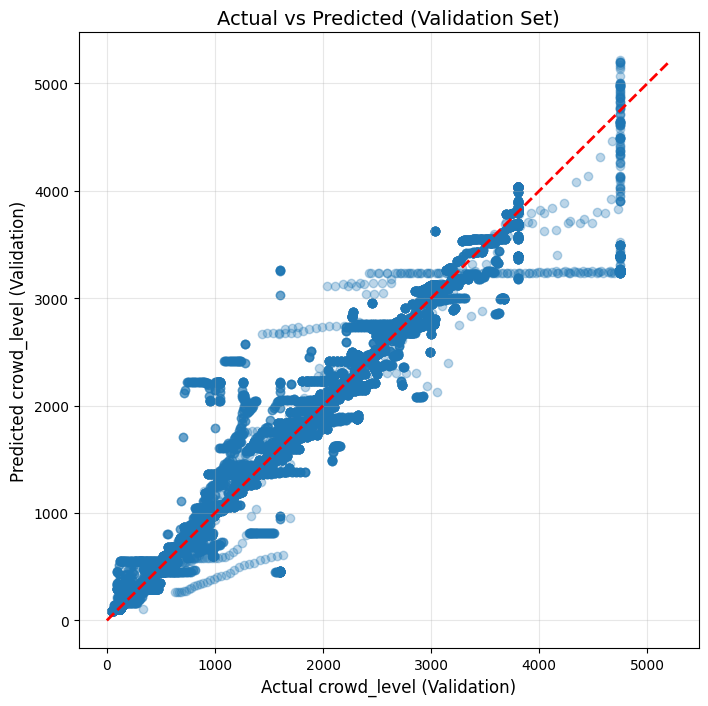

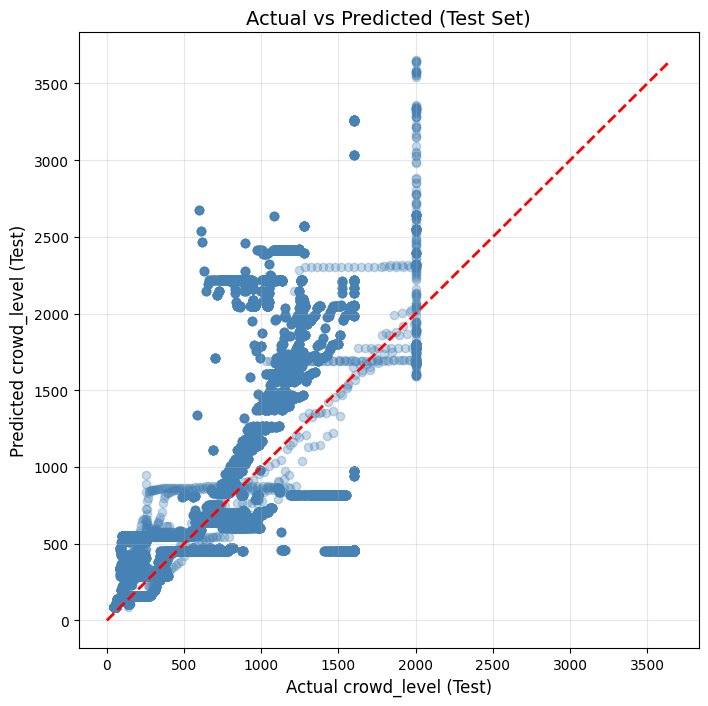

In [36]:
# ============================================================
#  Plot: Actual vs Predicted (Validation Set)
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred_val, alpha=0.3)

max_val = max(max(y_val), max(y_pred_val))
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)

plt.title("Actual vs Predicted (Validation Set)", fontsize=14)
plt.xlabel("Actual crowd_level (Validation)", fontsize=12)
plt.ylabel("Predicted crowd_level (Validation)", fontsize=12)

plt.grid(alpha=0.3)
plt.show()
# ============================================================
# Plot: Actual vs Predicted (Test Set)
# ============================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.3, color='steelblue')

max_val = max(max(y_test), max(y_pred_test))
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)

plt.title("Actual vs Predicted (Test Set)", fontsize=14)
plt.xlabel("Actual crowd_level (Test)", fontsize=12)
plt.ylabel("Predicted crowd_level (Test)", fontsize=12)

plt.grid(alpha=0.3)
plt.show()


# 📌 Difference Between Validation and Test Performance

The validation scatter plot shows that the predictions closely align with the diagonal reference line, indicating that the model performs reasonably well when evaluated on data that is temporally close to the training window. The relationship between actual and predicted values remains stable, and the prediction errors are relatively consistent across the range.

In contrast, the test scatter plot is much more dispersed, with many points deviating significantly from the ideal diagonal line. This dispersion reflects the model’s difficulty in generalizing to future data segments that follow different temporal patterns. The test window appears to contain new crowd dynamics or distribution shifts that the model has not learned, resulting in weaker predictive accuracy.


---


# 🎯 Summary

Validation accuracy appears acceptable because the data behaves similarly to the training period, leading to tighter clustering around the ideal prediction line. However, the test performance drops sharply due to temporal changes, new behavioral patterns, and variability not present in the training set. This visual difference clearly indicates that the model generalizes poorly to future unseen periods.

# Save Final Random Forest Model for Deployment

In [37]:
# ============================================================
# 11. Save Model and Encoding Dictionaries
# ============================================================

import joblib, json

joblib.dump(rf_model, "rf_station_total_30m.pkl")
json.dump(station_mapping, open("station_mapping.json", "w"))
json.dump(event_mapping, open("event_mapping.json", "w"))
